In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def test_data(molecular_descriptors_cleaned):
    
    test123 = molecular_descriptors_cleaned.loc[(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 81) 
                                        | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 60)
                                       | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 28)]
    
    test_data = test123.iloc[[0, 1, 3]] #It allows to get 3 different points of known activity
    
    return test_data
    

In [6]:
def prepare_model(data, features, test_data):
    
    X = data[features['molecular descriptor name']]
    
    y = data['Aktywność cytoprotekcyjna [%]']
    
    dtr = DecisionTreeRegressor(random_state=15)
    
    dtr.fit(X, y)
    print("Return the coefficient of determination of the prediction: ")
    print(dtr.score(test_data[features['molecular descriptor name']], test_data['Aktywność cytoprotekcyjna [%]']))

    pred = dtr.predict(X)
    print("R^2 score: "+ str(r2_score(y, pred)))
    sqrt_r2 = np.sqrt(r2_score(y, pred))
    training_data_r2 = r2_score(y, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = dtr.predict(test_data[features['molecular descriptor name']])
    print("R^2 score: "+ str(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])))
    sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(test_data['Aktywność cytoprotekcyjna [%]']) 
    test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])
    
    return dtr, training_data_r2, test_data_r2
    

In [7]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [8]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        test_ = test_data(stand)
        
        data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        test_ = test_data(data_to_be_prepared)
        
        data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [9]:
molecular_descriptors_df = prepare_data('../Data/Indole_-_cytoprotekcja_.xlsx')

 55%|████████████████████████████████████████████▋                                     | 24/44 [00:01<00:01, 18.64it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 22.47it/s]


(44, 1613)
(44, 1433)
(44, 1182)


In [10]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.3, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455        

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


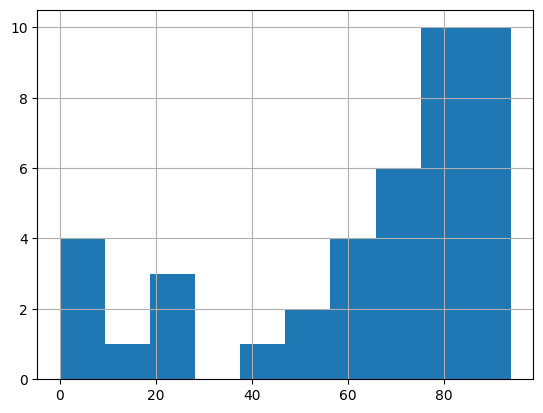

In [11]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [12]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 21


In [13]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
137,AATSC3c,-0.319623,0.319623
455,BCUTare-1h,0.323770,0.323770
456,BCUTare-1l,0.345707,0.345707
468,BCUTp-1l,-0.321204,0.321204
469,BCUTpe-1h,0.317690,0.317690
476,BCUTv-1l,-0.325136,0.325136
520,ETA_dEpsilon_D,0.412783,0.412783
566,GATS3c,0.308343,0.308343
614,GATS7c,0.310103,0.310103
706,MATS3c,-0.317344,0.317344


In [14]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.3, True)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [15]:
with_standarization.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 15,
 'splitter': 'best'}

In [16]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([82., 82., 82., 82., 82., 82., 82., 85., 85., 85., 85., 85., 85.,
       82., 85., 85., 82., 85., 85., 85., 85., 82., 85., 82., 85., 82.,
       85., 85., 85., 85., 85., 85., 82., 82., 82., 82., 82., 85., 85.,
       85., 85., 85., 85., 85.])

In [17]:
len(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]))

44

In [18]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [19]:
xs

-557.4011135318324

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


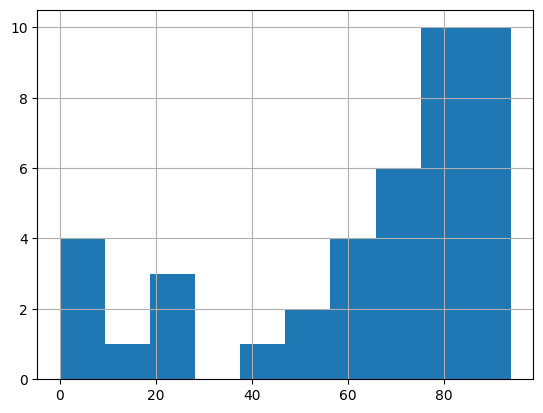

In [20]:
print('Target distribution histogram: ')
print(hist1_['Aktywność cytoprotekcyjna [%]'].hist())

In [21]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 21


In [22]:
hist2_

,molecular descriptor name,corr_value,absolute correlation value
137,AATSC3c,-0.319623,0.319623
455,BCUTare-1h,0.323770,0.323770
456,BCUTare-1l,0.345707,0.345707
468,BCUTp-1l,-0.321204,0.321204
469,BCUTpe-1h,0.317690,0.317690
476,BCUTv-1l,-0.325136,0.325136
520,ETA_dEpsilon_D,0.412783,0.412783
566,GATS3c,0.308343,0.308343
614,GATS7c,0.310103,0.310103
706,MATS3c,-0.317344,0.317344


## Search inside correlation space

In [23]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53         

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [24]:
df_without_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])

In [25]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list

In [26]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.25,1.000000,-26.575269,46
1,0.26,1.000000,-18.666227,38
2,0.27,1.000000,-31.976190,30
3,0.28,1.000000,-26.575269,28
4,0.29,1.000000,0.694434,26
5,0.30,1.000000,-2.010518,21
6,0.31,1.000000,-4.131347,20
7,0.32,1.000000,-2.395791,15
8,0.33,1.000000,-3.252877,12
9,0.34,1.000000,0.262075,9


In [27]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, True)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
455                BCUTare-1h    0.323770                    0.323770
45

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2616534483.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [28]:
df_with_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])
df_with_standarization['Training data R^2 score'] = second_list
df_with_standarization['Test data R^2 score'] = third_list
df_with_standarization['Number of features'] = f_list

In [29]:
df_with_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.25,1.000000,-2.725049,46
1,0.26,1.000000,-18.345361,38
2,0.27,1.000000,-23.259259,30
3,0.28,1.000000,-26.575269,28
4,0.29,1.000000,0.694434,26
5,0.30,1.000000,-2.010518,21
6,0.31,1.000000,-3.459057,20
7,0.32,1.000000,-3.252877,15
8,0.33,1.000000,-2.395791,12
9,0.34,1.000000,0.262075,9


## Plots

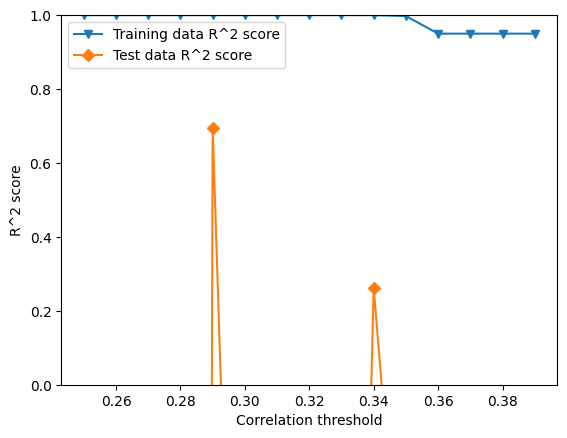

In [30]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Training data R^2 score'], label = "Training data R^2 score", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Test data R^2 score'], label = "Test data R^2 score", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R^2 score')
plt.ylim([0, 1])
plt.show()

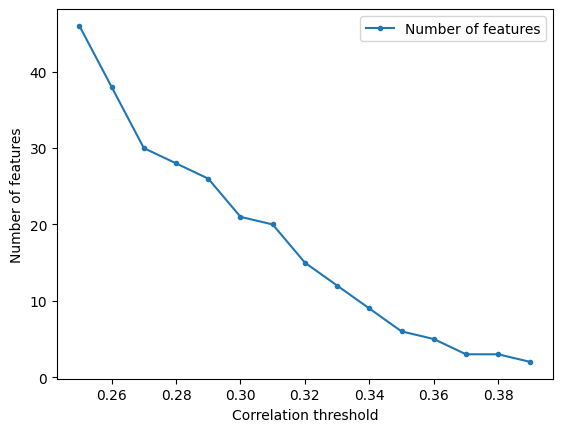

In [31]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

# sqrt(R^2)

In [32]:
df_without_standarization['train R value'] = [np.sqrt(x) for x in df_without_standarization['Training data R^2 score']]

In [33]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,train R value
0,0.25,1.000000,-26.575269,46,1.000000
1,0.26,1.000000,-18.666227,38,1.000000
2,0.27,1.000000,-31.976190,30,1.000000
3,0.28,1.000000,-26.575269,28,1.000000
4,0.29,1.000000,0.694434,26,1.000000
5,0.30,1.000000,-2.010518,21,1.000000
6,0.31,1.000000,-4.131347,20,1.000000
7,0.32,1.000000,-2.395791,15,1.000000
8,0.33,1.000000,-3.252877,12,1.000000
9,0.34,1.000000,0.262075,9,1.000000


In [34]:
xcz = []
for element in df_without_standarization['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_15492\2727130492.py:3: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(element)


In [35]:
xcz

[0, 0, 0, 0, 0.8333272534390053, 0, 0, 0, 0, 0.5119327437937112, 0, 0, 0, 0, 0]

In [36]:
df_without_standarization['test R value'] = xcz

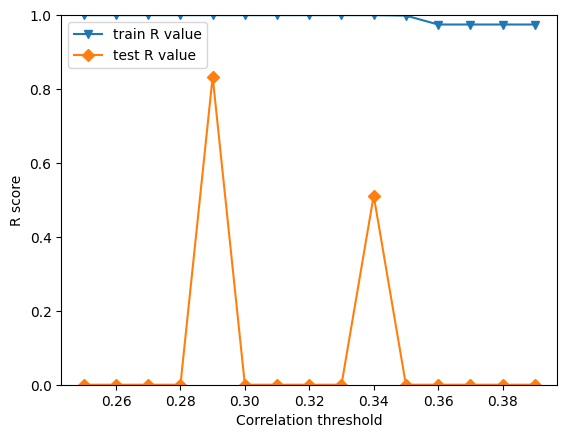

In [37]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['train R value'], label = "train R value", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

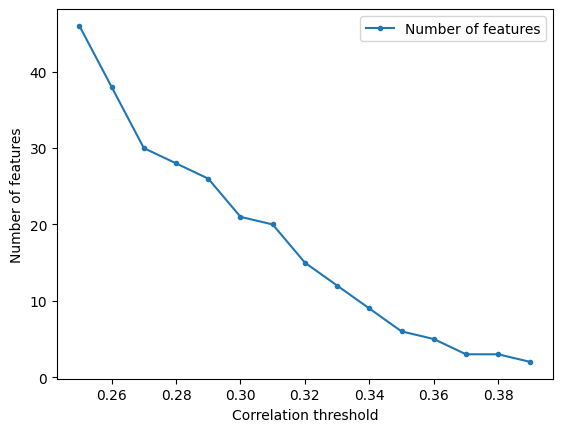

In [38]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [39]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False)

## Predict target feature

In [ ]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_indole_tanimoto_similarity_.xlsx')

In [ ]:
predicted_activity = final_model[0].predict(to_prediction[final_model[4]['molecular descriptor name']])

In [ ]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_indole_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [ ]:
print(len(smiles))
print(len(predicted_activity))

In [ ]:
save_to_df.head()

In [ ]:
save_to_df['Predicted activity'] = predicted_activity

In [ ]:
save_to_df.head()

In [ ]:
save_to_df.to_excel('../Data/Predicted_activity.xlsx')